# PRÁCTICA 1 - APRENDIZAJE PROFUNDO - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

# JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

# Lab: RNNs for Time Series Prediction


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this notebook, you will deploy a simple probabilistic model using a RNN to infer the probability distribution of a time-series. Given a set of signals  $\mathcal{D}=\{X^1,X^2,\ldots,X^N\}$ where $$X^i = [X_0^i,X_1^i,\ldots,X_T^i]$$
is the $i$-th signal, we will train a probabilistic model of the form
$$p(X|X_0) = \prod_{t=1}^T p(X_t|\mathbf{X}_{0:t-1})$$
where $\mathbf{X}_{0:t-1}=[X_0,X_1,\ldots,X_{t-1}]$ and every conditional factor $p(X_t|\mathbf{X}_{0:t-1})$ corresponds to a Gaussian distribution with mean and variance obtained **from the state of a RNN** with input $X_{t-1}$. The RNN state $\mathbf{h}_{t-1}$ is a projection of the the signal up to time $t-2$, i.e, $\mathbf{X}_{0:t-2}$:

$$p(X_t|X_{t-1},\mathbf{X}_{0:t-2}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2+g_{RNN}(X_{t-1},\mathbf{h}_{t-1})\right)$$,
where $\sigma^2$ is a constant basal variance that we treat as an hiper-parameter. During training, we approximate the expected loss at time $t$
$$\mathcal{L}_t=\mathbb{E}_{\hat{X}_t\sim p(X_t|X_{t-1},\mathbf{X}_{0:t-2})}[(X_t-\hat{X}_t)^2]$$
using a single sample of $p(X_t|X_{t-1},\mathbf{X}_{0:t-2})$. The global loss is accumulated during the whole signal length:

$$\mathcal{L} = \frac{1}{T}\sum_{t=1}^T \mathcal{L}_t$$

**Important:** during training, we **feed the RNN with the true values of the signal**. Namely, at each time point $\mathbf{h}_{t-1}$ is calculated with the true values of the signal. This strategy is known as **teaching forcing**.




Cremos un modelo probabilístico usando RNN para modelar/descubrir la distribución de probabilidad de una serie temporal. Tendremos un conjuntos de series temporales o señales D = {X^1, X^2, ... , X^N}. Cada una de ellas tendrá la siguiente estructura X^i = [X^i_0, X^i_1, ..., X^i_T] (donde cada "X^i_j" es un valor discreto de la señal).

Buscaremos ls densidad de probabilidad de una serie en concreto y con eso seremos capaces de predecir la media y varianza de un nuevo posible dato de la serie o una secuencia entera.

La función de coste se relacionará directamente con el error cuadrático medio de las predicciones y los valores reales.

In [1]:
# Importamos las librerías necesarias para el desarrollo de la práctica

import torch
from torch import nn
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part I. Create a synthetic database

We will generate $N$ target signals of length $T$ time steps. We generate each signal as one realization of the following autoregressive model
\begin{align}
X_{t}=c+\sum_{i=1}^{p} \varphi_{i} X_{t-i}+\varepsilon_{t}
\end{align}
where $\varepsilon_{t}\sim \mathcal{N}(0,\sigma_{\epsilon})$ and $c$,$\varphi_{i}$ $i=1,\ldots,p$ are real coefficients.



Crearemos una BBDD sintética, para ello vamos a generar N señales con una longitud de T pasos en el tiempo.

Cada señal se forma a través de los valores de la señal antigua en el tiempo, un valor que depende de una distribución normal y coeficientes reales.

In [2]:
!pip install statsmodels

We use the library [statsmodel](https://www.statsmodels.org/stable/index.html) to generate the above signals ...

In [3]:
# We  statsmodels

import statsmodels.api as sm

maparams = []
arparams = np.array([.35, .35,0.75,-0.65,-0.15,0.01]) #phi coefficients

ar = np.r_[1, -arparams] # array con 1 y los valores de -arparms
ma = np.r_[1, maparams] # array con 1
model = sm.tsa.ArmaProcess(ar, ma) # We use c=0 y and unit variance for the noise

In [4]:
N = 1000 # Creamos 1000 señales

T = 300 # Cada una tendrá 300 unidades de tiempo

X = model.generate_sample((N,T),axis=1,burnin=50) # We ignore the 50 first samples of every signal (efecto del burnin)

In [5]:
X.shape # Vemos como contamos con 1000 señales de 300 unidades de duración

(1000, 300)

Given the set of signals, let's create the targets just like the original offset signals:


In [6]:
# Con esto tenemos el target Y y el input X (que es igual a Y pero movida a la derecha una unidad de tiempo)

Y = X[:,1:] 
X = X[:,:-1] 

T -=1

Lets plot one of the signals versus the *target*, which is the same signal but shifted to the right ...

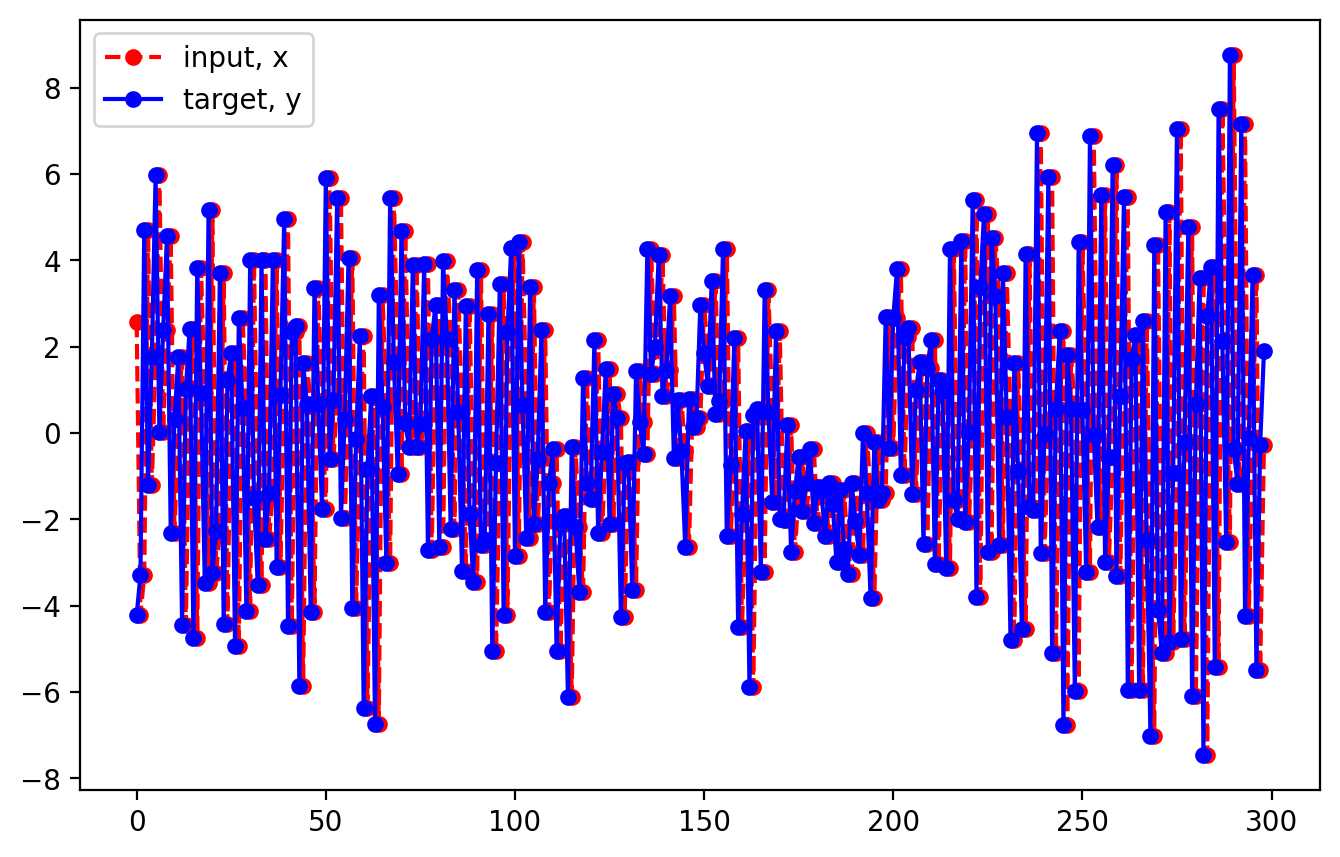

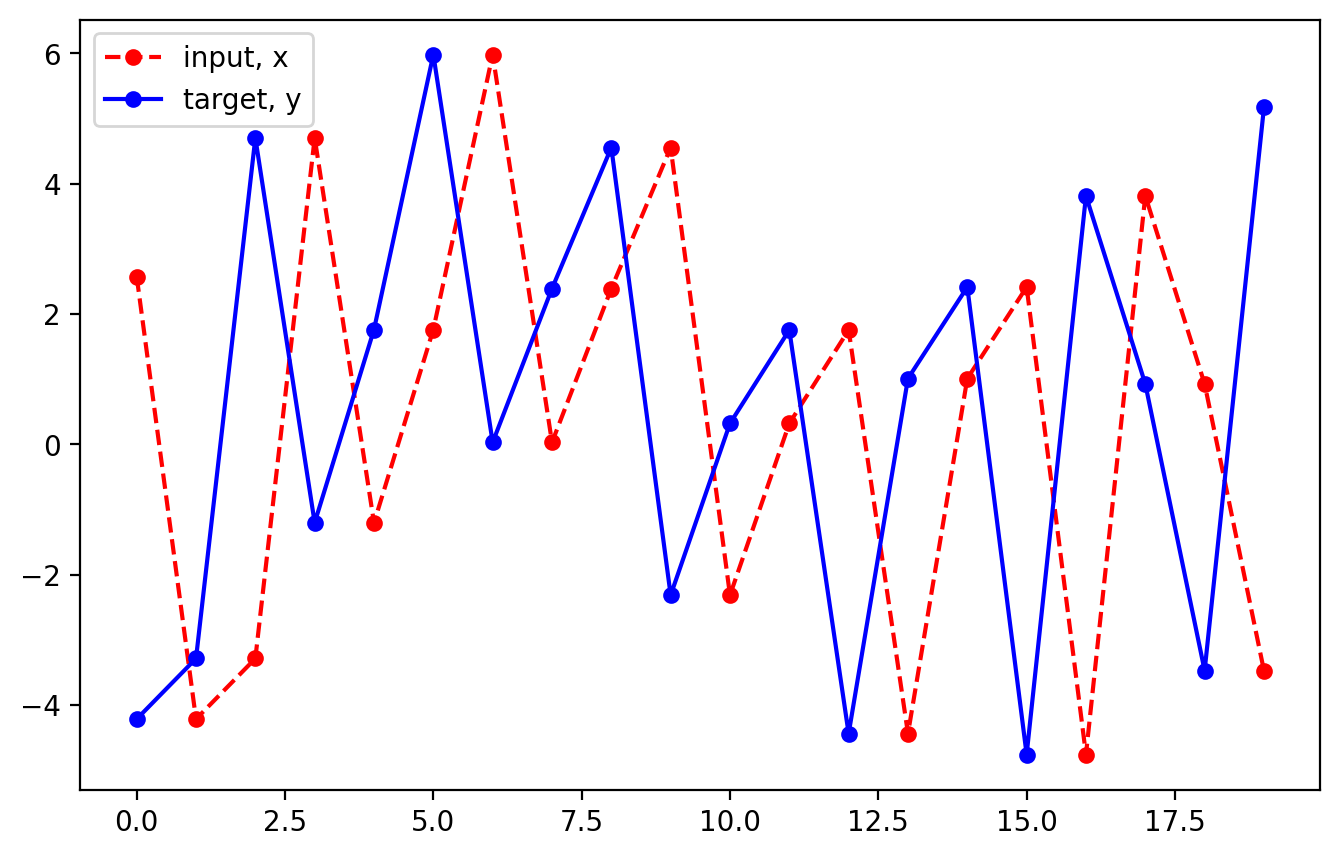

In [7]:
# Plot the signal 
plt.figure(figsize=(8,5))
plt.plot(np.arange(T), X[1,:T], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(T), Y[1,:T], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

# Plot the signal (20 first steps)
plt.figure(figsize=(8,5))
plt.plot(np.arange(20), X[1,:20], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(20), Y[1,:20], 'b.-', label='target, y',ms=10) # y

plt.legend(loc='best')

La idea es la siguiente: Yo necesito una forma de evaluar la capacidad de predicción de la siguiente sample temporal de mi RNN a través de una función de coste. Es por ello que utilizo como target a buscar la señal desplazada una posición a la izquierda. Haciendo que el target esté una posición a la izquierda de la señal real, la señal que aprenderá a crear mi RNN estará una posición a la izquierda de la original y podré hacer predicciones de muestras futuras de la serie temporal y evaluar la calidad con la que mi RNN es capaz de hacer esto.

## Part II. Define RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, which takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the dimension of the RNN output and the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a **stacked RNN** 


This is an example of a stacked RNN

<img src="https://yiyibooks.cn/__src__/wizard/nmt-tut-neubig-2017_20180721165003_deleted/img/6-5.jpg" width="40%"> 


If you take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn), you will see that `nn.RNN` only provides the actual computation of the hidden states along time
\begin{align}
h_{t}=g \left(W_{i h} x_{t}+b_{i h}+W_{h h} h_{(t-1)}+b_{h h}\right)
\end{align}

Then we'll add a last, fully-connected layer to get the output size that we want. For simplicity, **the input to this dense layer is the state $h_t$ of the RNN**.

You have to pay special attention to the dimensions of the input/output tensors of the RNN. **Check the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn)**.




Pasaremos a definir una RNN en Pytorch usando nn.RNN para crear una capa RNN. Cada capa RNN tiene = input_size (tamaño de los datos de entrada one, many...) ; hiddem_dim (dimensión de la salidas de la RNN y el estado oculto (ya que las salidas son el estado oculto multiplicado por unos pesos)) y n_layers (número de capas en la RNN; si es más de 1 crearemos una STACKED RNN).

The following class implements a class where 
- An input signal of dimension `input_size` is processed by a RNN. As a result, we obtain a sequence of states $\mathbf{h}_{t}$, from $t=1$ to $t=T$.
- We process each state with a linear layer to estimate the mean and variance of the output signal at time $t$ from $\mathbf{h}_{t}$. Both the mean and variance are of dimension (`output_size`). Thus, the output dimension of the linear layer is 2*`output_size`. The first components will be the mean, while the last `output_size` components are the log-variance.
- The `forward` method also return a sample of the estimated signal.


La siguiente clase implementa: 

-Una señal de entrada con tamaño "input_size" procesada por una RNN donde obtenemos una secuencia de estados ocultos (desde el de t=1 hasta el de t=T de la señal de entrada).

-A la salida de cada celula de RNN, cada estado oculto es procesado por dos MLPs, uno para estimar la varianza y otro para la media del dato de la siguiente posición temporal/Celula_RNN

-Cada output_size será de 2 donde la primera componente es la media y la última, la log-varianza.

-El método forward también devuelve una muestra de la señal estimada

> **Exercise**: complete the following code. Understand all steps, particularly those in the `forward` method.

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim # Dimensión de los estados ocultados de la células RNN.  A más tamaño, más explicativo y preciso es el funcionamiento pero mayor es el coste computacional por el gasto en parámetros.
        
        self.input_size = input_size # Dimensión del vector de datos a la entrada de cada célula de la RNN. Al final la RNN ve cada entrada en el tiepo y no la length tota. Es por ello que será 1 ya que a cada célula solo entra el valor real de la muestra temporal de la serie en ese instante

        self.output_size = output_size # Dimensión de la salida de la RNN. En este caso es 1 y de ese valor se obtiene la media y su varianza.
        
        self.sigma = torch.Tensor(np.array(sigma))

        # define an RNN with specified parameters
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, 
                          nonlinearity='relu',batch_first=True) # Usará funciones de activación ReLu en la función que genera ht en vez de usar la típica tanh (ReLu(xt*....))
                          # Por otro lado, con batch_first = True conseguimos que la dimensión del input que introducimos (en este caso de 299), es el tamaño de batch que le vamos a ir pasando a la RNN (todas nuestras señales tienen la misma longitud)
                          # Si yo pusiera false, implicaria una variación del input-length a lo largo de muestras en el tiempo
        
        # last, two fully-connected layer
        # One linear layer to estimate mean
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE
        # One linear layer to estimate log-variance
        self.fc2 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

    def forward(self, x, h0=None):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the RNN hidden state h0 has shape (n_layers, batch_size, hidden_dim).
          If None value is used, internally it is initialized to zeros.
        - The RNN output (batch_size, seq_length, hidden_size). This output is the RNN state along time  

        '''
        
        batch_size = x.size(0) # Number of signals N (el tamaño de batch es, en este caso, la database completa; 1000 muestras (1000 señales))
        seq_length = x.size(1) # T (cada secuencia tiene T valores)
        
        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state (we will use it for forecasting)
        r_out, hidden = self.rnn(x, h0) # Introduciendo a la rnn los datos de entrada (una de las series) y el estado h0 de la célula inicial (que lo ponemos como todo 0s), obtenemos la secuencia de estados ocultos (h1,h2,...hT-1) y hidden que es el hlast que usaremos para crear nuevos valores de las propias series
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) # Con esto el shape de r_out será Tx32 (o la hidden puesta); De esta manera, cada fila es un valor de la muestra de una serie y cada columna su estado
        # De esta manera se queda cada entrada al MLP el hidden state al completo de cada posición del tiempo para la señal que estemos introduciendo a la entrada
        
        # First output_size components are the mean
        mean = self.fc1(r_out)
             
        # We compute the variance
        variance = torch.exp(self.fc2(r_out))+torch.ones(mean.shape)*self.sigma
        
        # We generate noise of the adecuate variance
        noise = torch.randn_like(mean)*torch.sqrt(self.sigma)
        
        sample = mean+noise
        
        # reshape back to temporal structure
        sample = sample.reshape([-1,seq_length,int(self.output_size)]) # Vector con las muestras predichas del siguiente punto 
        mean = mean.reshape([-1,seq_length,int(self.output_size)]) # Vector de medias en cada instante temporal
        variance = variance.reshape([-1,seq_length,int(self.output_size)]) # Vector de varianzas en cada instante temporal
        
        return mean, variance, hidden, sample


> **Exercise:** Instantiate the object RNN with the right parameters for our problem. Use `hidden_dim=32`, `n_layers=1` and `sigma=1`

In [9]:
# test that dimensions are as expected
my_rnn = RNN(input_size=1, output_size=1, hidden_dim=32, n_layers=1, sigma=1) 

In the following code, we compute the model output using the `forward` method. Note that we use an all zero initial state.

> **Exercise**: Using the `forward` method, compare the signal predicted mean against the true value during the first 20 time instants for one of the signals. Note that the parameters of the RNN have not been trained...



La dimensión del estado es
torch.Size([1, 1000, 32])

La dimensión de predicción es
torch.Size([1000, 299, 1])


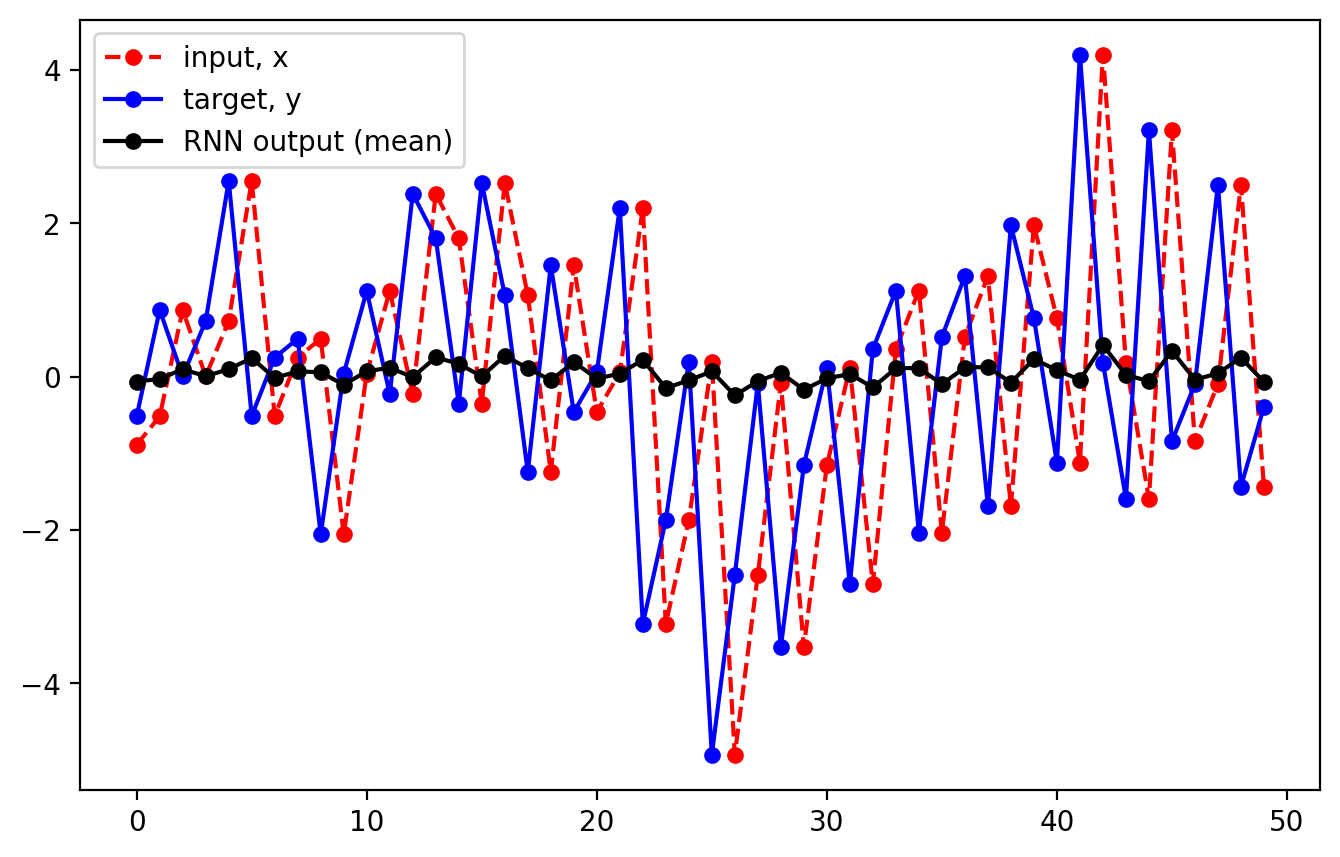

In [10]:
X_in = torch.Tensor(X).view([-1,T,1])

mean,std,h,sample = my_rnn.forward(X_in) # YOUR CODE HERE

print(f'La dimensión del estado es')
print(h.shape)

print(f'\nLa dimensión de predicción es')
print(mean.shape)

output_no_train = mean.detach().numpy().reshape([T,-1])

# Instante incial para la representación
t0 = 0

# Instante final
tf = 50

signal = 0 # Ejemplo de señal

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) 
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) 
plt.plot(np.arange(t0,tf,1), output_no_train[signal,t0:tf], 'k.-', label='RNN output (mean)',ms=10) 
plt.legend()

En la dimensión de predicción vemos como tenemos las medias predichas de las 299 posiciones en el tiempo de las 1000 series temporales generadas e introducidas a la RNN.

Como la RNN no ha sido entrenada, los pesos estan (lógicamente), sin entrenar y las predicciones (la salida de la RNN), es realmente mala.

> **Exercise:** Complete the code for the following class, which extends `RNN` to include a training method. 

Note that there is no mini-batch, we process all signals for every SGD iteration. You are free to the mini-batch training functionality. 
Another novelty, typically associated with RNNs, is limiting the absolute value of the gradients (*gradient clipping*) to a preset value (2.0 in the code). When processing very long sequences, the product of terms associated with *backpropagation* can trigger gradients that are too large ([*exploiding gradients*](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf)) that cause instabilities in gradient descent. With *gradient clipping* we prevent this situation.

In [11]:
class RNN_extended(RNN):
    
    #Your code here
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()   
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length,1]) 

            y = torch.Tensor(y).view([self.num_train,self.sequence_length,1]) 

            mean,std,hid,sample = self.forward(x)
                
            loss = self.criterion(sample,y) # Compararemos la sample predicha con la serie "y" (son las que deben ser iguales para poder predecir puntos futuros evaluando la calidad de la RNN)
            
            #loss.requires_grad = True
            
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))                

> **Exercise:** Using only the first 100 values of every signal, train the RNN for 200 SGD iterations. Use `hidden_dim=32`, `n_layers=1` and `sigma=0.1`. Recall that the target signal is stored in the variable `Y`.

In [15]:
T_train = 100

my_rnn = RNN_extended(num_data_train=X.shape[0],num_iter=200,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=0.1,lr=0.005)

In [16]:
my_rnn.trainloop(X[:,:T_train],Y[:,:T_train]) #YOUR CODE HERE

Iteration 0. Training loss: 0.030039
Iteration 50. Training loss: 0.006242
Iteration 100. Training loss: 0.006053
Iteration 150. Training loss: 0.006053


> **Exercise:** Plot the loss function along training




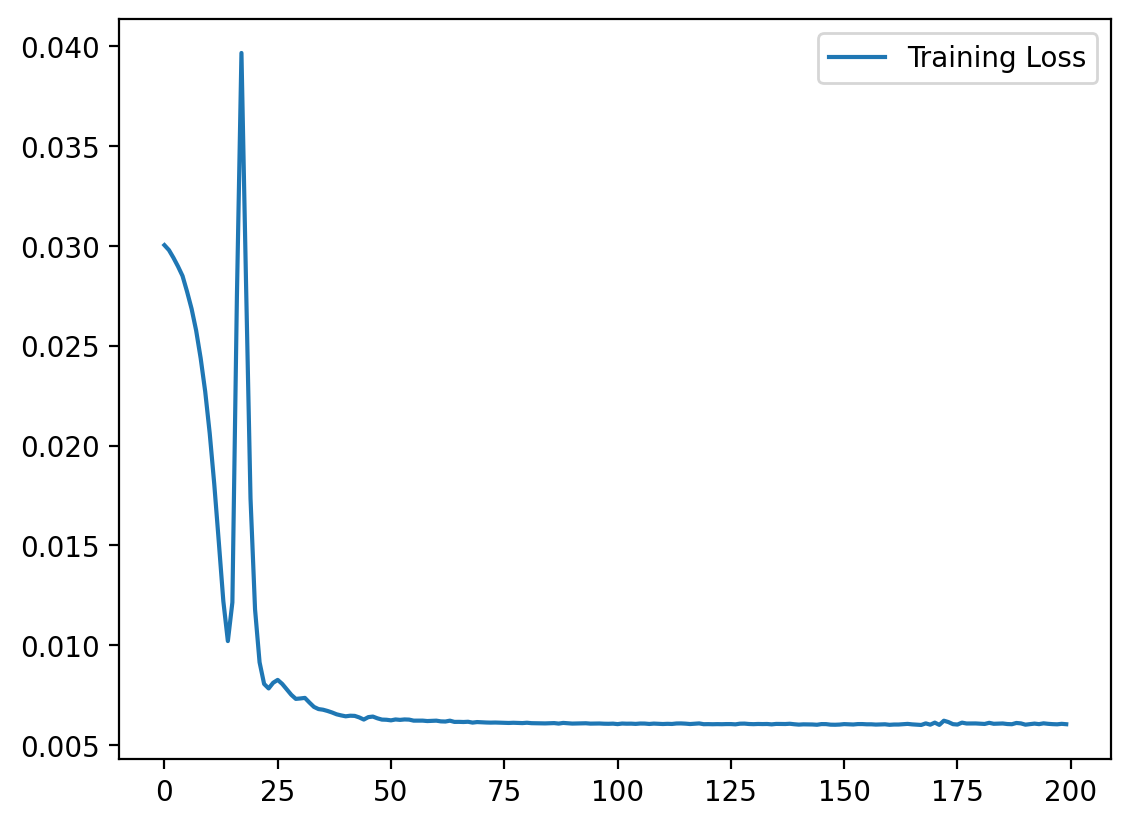

In [17]:
plt.plot(my_rnn.loss_during_training,label='Training Loss')
plt.legend()

Ese pico nace de la cierta inestabilidad generada por las propias RNN, sin embargo, no es nada preocupante. Con el fin de ver mejor la evolución de la loss_function, aplicaremos un zoom al eje Y

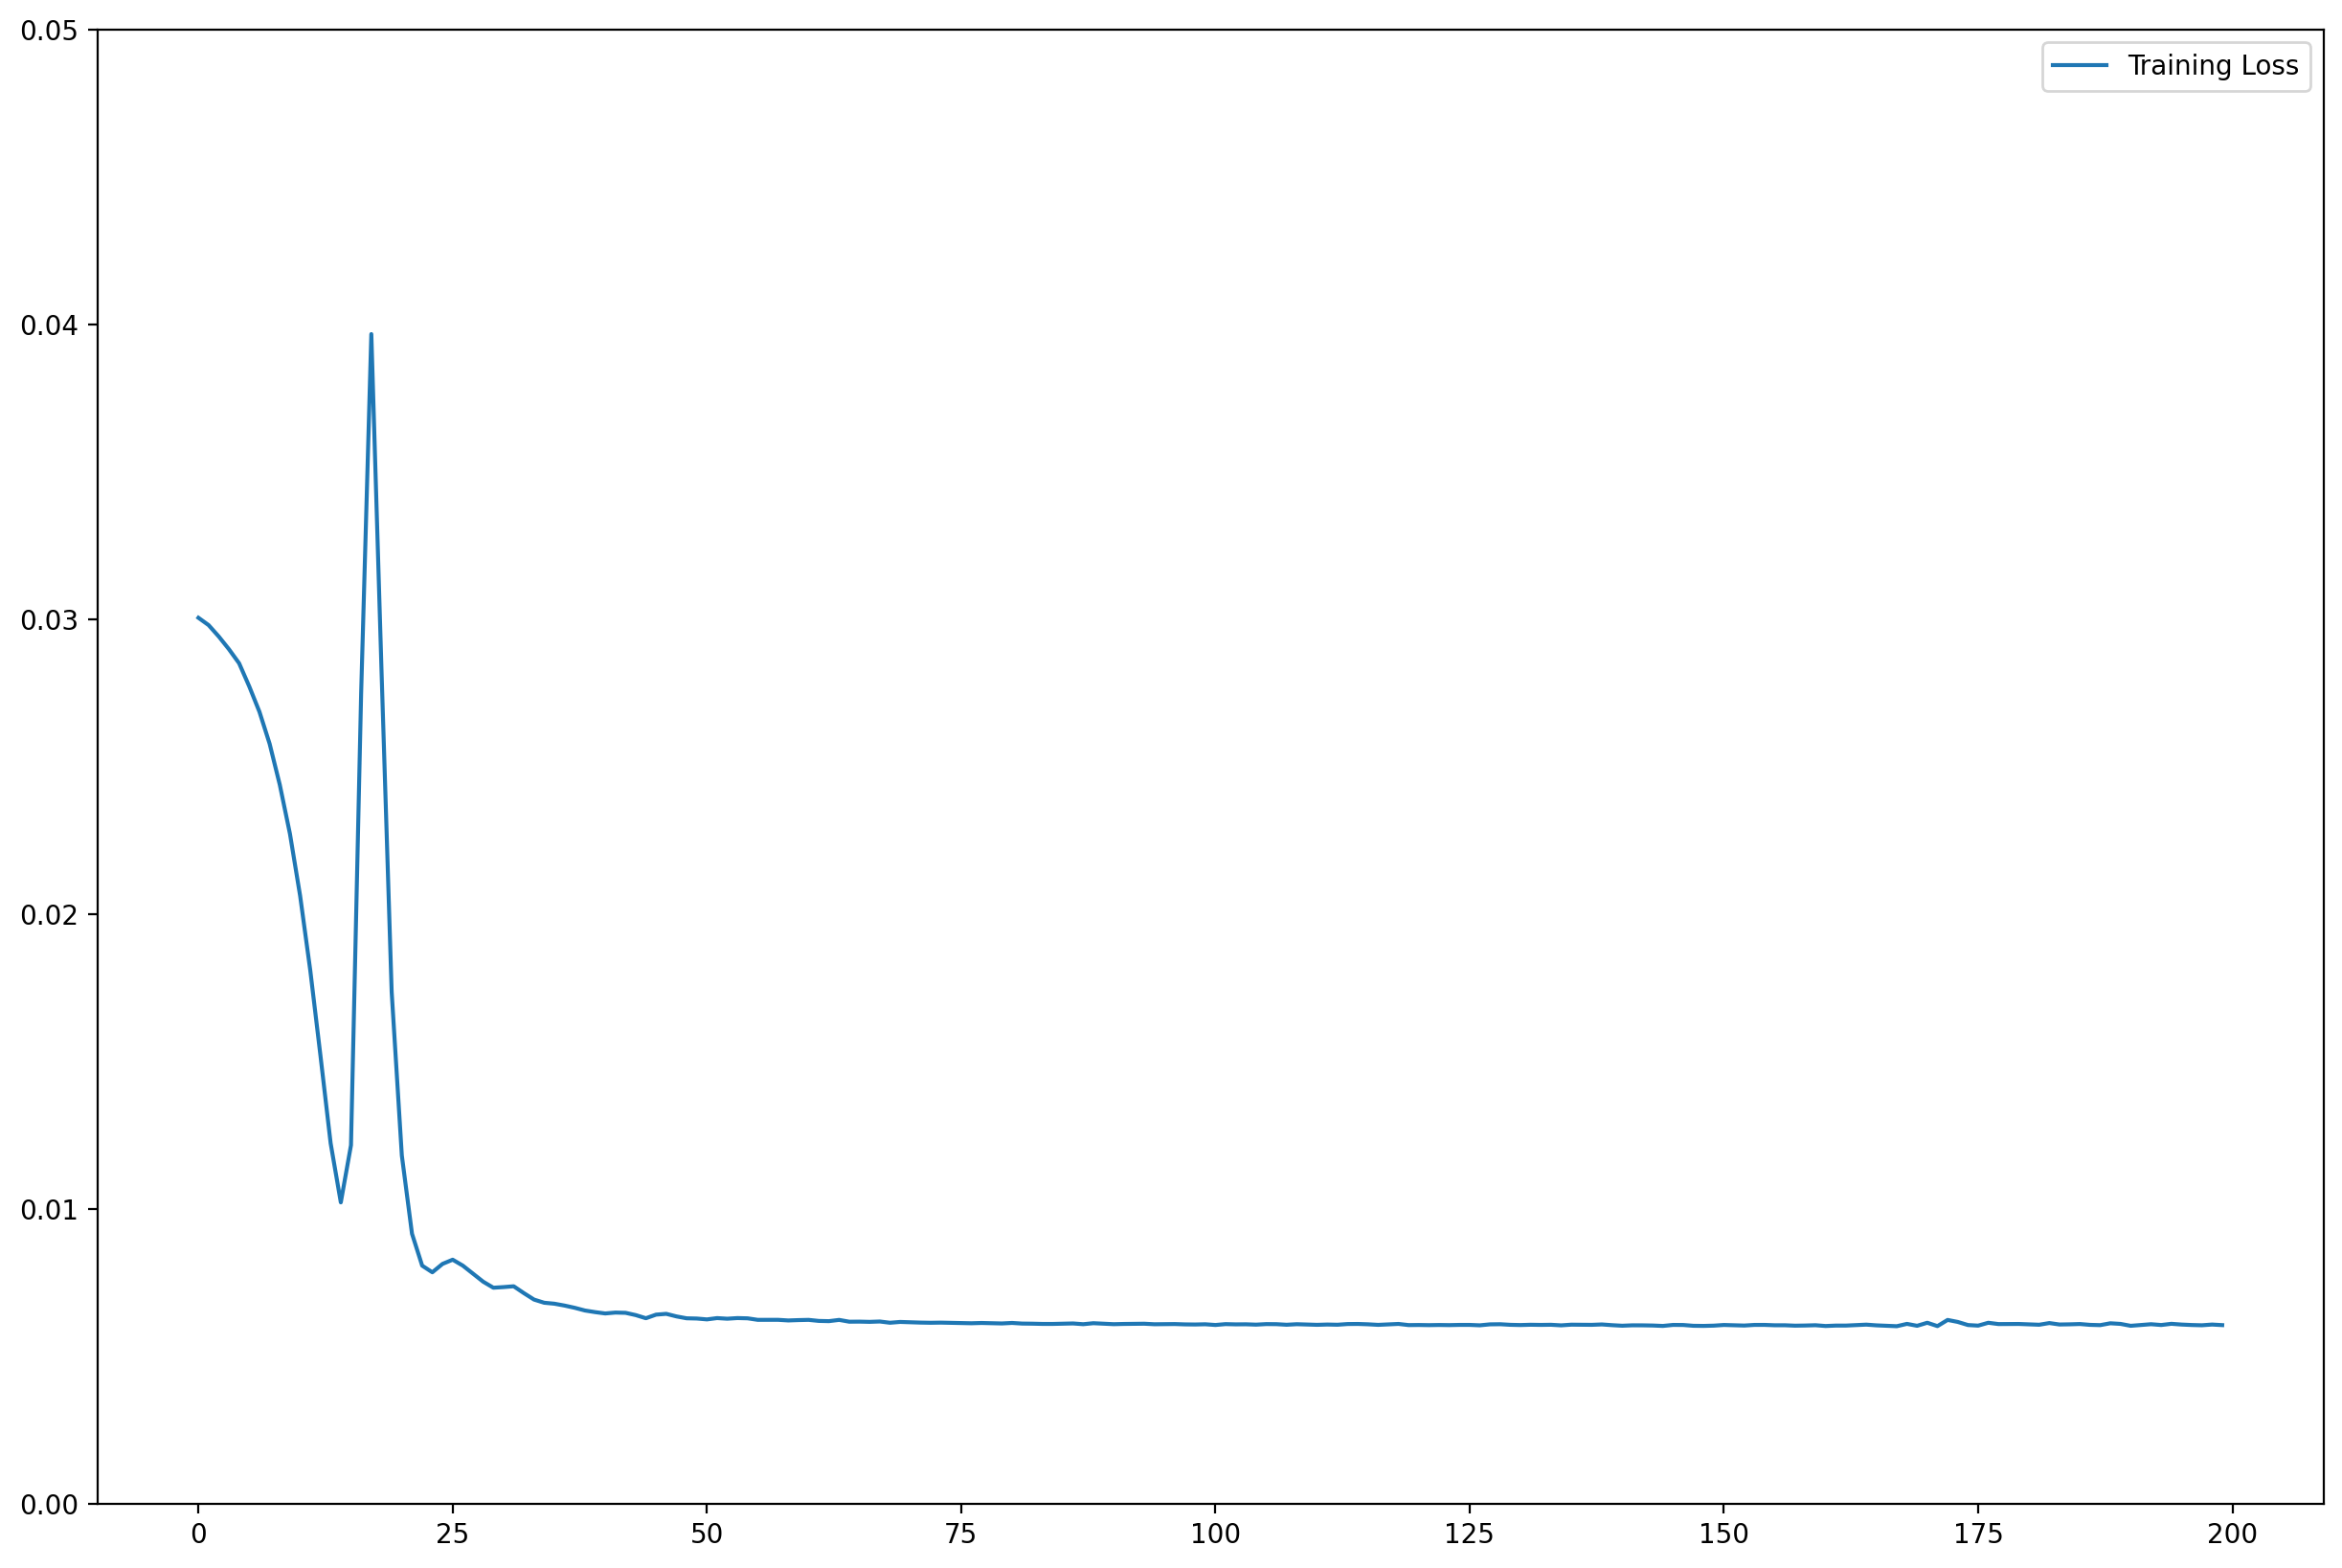

In [18]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_rnn.loss_during_training,label='Training Loss')
ax.set_ylim(bottom = 0, top = 0.05)
ax.legend()

Obviando la discontinuidad, vemos un buen rendimiento en el descenso del valor de la función de loss que aplica a un funcionamiento correcto de nuestra RNN.

> **Exercise:** Compute the following plot, in which we plot one of the input signals, the target one, and the prediction (mean $\pm$ two stds) by the RNN from t=20 to t=70

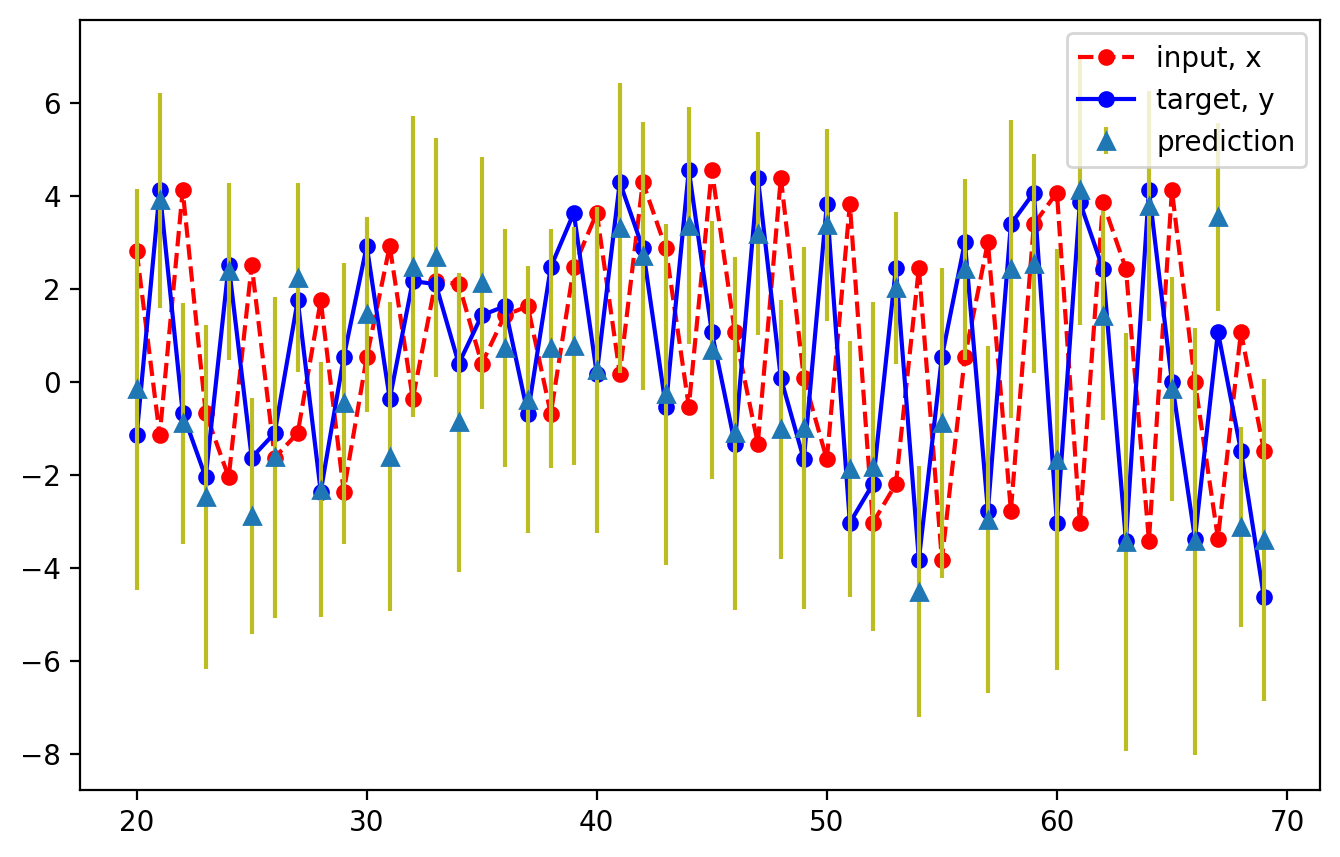

In [21]:
# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view([N,T_train,1]) 

mean,var,h,sample = my_rnn.forward(X_in) # YOUR CODE HERE

mean_rnn = mean.detach().numpy().reshape([N,-1])
std_rnn = np.sqrt(var.detach().numpy().reshape([N,-1]))

# Initial time point of the representation
t0 = 20

# Final point
tf = 70

signal = 5 # From 1 to N (you can play with this)

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) # x
plt.errorbar(np.arange(t0,tf,1), mean_rnn[signal,t0:tf], 2*std_rnn[signal,t0:tf], linestyle='None', marker='^',ecolor='tab:olive',label='prediction')




plt.legend(loc='best')

Teniendo en cuenta que los triangulos son los valores medios predecidos y las lineas verdes hace referencia a la varianza, podemos ver como la señal predicha por la RNN en referencia al target buscado (la señal original desplazada una unidad de tiempo a la izquierda), es realmente buena. Añadiendo el poco coste computacional y lo rápido que ha sido el entrenamiento (solo 200 mini-batches), podemos concluir en que hemos obtenido realmente buenos resultados.

De esta manera vemos como la RNN ha aprendido bien la estructura de las series del dataset y tiene capacidad de predicción al siguiente punto temporal.

Observe that the prediction is pretty good!The RNN model have clearly learnt the dynamics of the dataset. In the previous experiment, note we have fed the RNN model with the **true** values of the signal, i.e. we have used the full signal $X$ to compute the sequence of states. 

Using the model we have just trained, lets do now **forecasting**. Namely, we feed the RNN the output that we predicted and we do this recursively for as long as we want. This represents **sampling** from the probabilistic model 

$$p(X|X_0) = \prod_{t=1}^T p(X_t|\mathbf{X}_{0:t-1})$$
$$p(X_t|X_{t-1},\mathbf{X}_{0:t-2}) = \mathcal{N}\left(f_{RNN}(X_{t-1},\mathbf{h}_{t-1}),\sigma^2+g_{RNN}(X_{t-1},\mathbf{h}_{t-1})\right)$$

To do forecasting, note that we have to recursively call the `forward` method and feed the obtained RNN output and state as the entry and initial state for the next `forward` call. The following code would do the job:

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


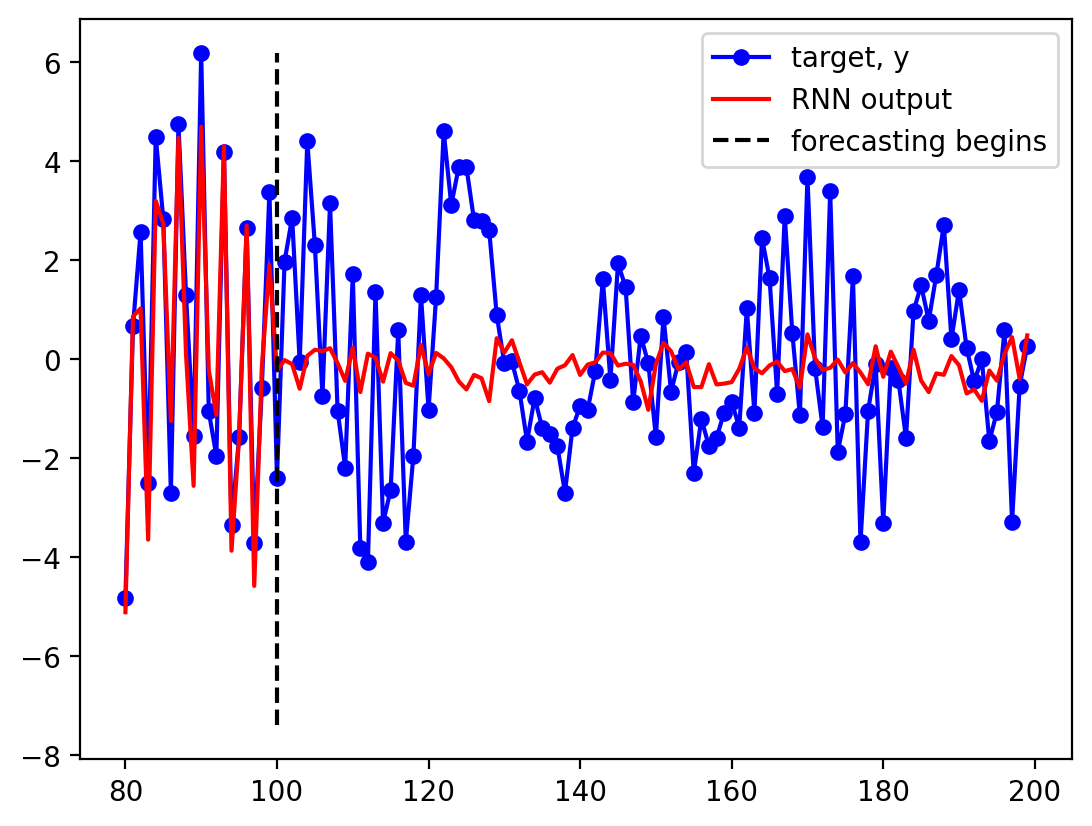

In [22]:
# We take the last output of the RNN for the N signals at time T_train
current_input = sample[:,-1,:].view([N,1,1]) 
# And the last state
current_state = h

# Here we store the sampled signals
forecast_rnn = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # En este bucle muestreamos iterativamente el modelo
    
    mean,var,current_state,current_input = my_rnn.forward(current_input) 
    
    forecast_rnn[:,t] = current_input.detach().numpy().reshape([-1,])

    
# We concatenate the original ones (until T_train) with the ones we just sampled (from T_train)    
final_rnn_reconstruct = np.hstack([mean_rnn,forecast_rnn])

# Now we plot

t0 = 80

tfinal = 200

plt.plot(np.arange(t0,tfinal,1), Y[signal,t0:tfinal].reshape([-1]), 'b.-', label='target, y',ms=10)  
plt.plot(np.arange(t0,tfinal,1), final_rnn_reconstruct[signal,t0:tfinal], 'r-', label='RNN output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--',label='forecasting begins')
plt.legend()

plt.legend(loc='best')
print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

Dada la corta memoria de las RNN, no son demasiado capaces de entender patrones largos y relacionarlos entre sí por lo que vemos como, a partir de que empiece el forescasting, las predicción de las muestras por parte de nuestra red en comparación a los valores reales, es relativamente mala.

Observe that, after a while, the model deviates from the true realization. That is **expected** we are sampling from the generative model and it is likely that do not get exactly the same sample! Particularly in RNN, since they have short memory.

## LSTMs

Lets study how an LSTM would perform in this context. You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. If **stacked LSTMs (n_layers>1) are used** we can automatically add dropout between LSTM layers with te parameter `dropout` with a specified probability.

> **Exercise:** Complete the code for the following two classes 

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,sigma,drop_prob):
        
        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN
        
        super().__init__()
        
        self.hidden_dim = hidden_dim # Dimensión de los estados ocultados de la células LSTM.  A más tamaño, más explicativo y preciso es el funcionamiento pero mayor es el coste computacional por el gasto en parámetros.
        
        self.input_size = input_size # Dimensión del vector de datos a la entrada de cada célula de la LSTM. Al final la LSTM ve cada entrada en el tiepo y no la length tota. Es por ello que será 1 ya que a cada célula solo entra el valor real de la muestra temporal de la serie en ese instante

        self.output_size = output_size # Dimensión de la salida de la LSTM. En este caso es 1 y de ese valor se obtiene la media y su varianza.
        
        self.sigma = torch.Tensor(np.array(sigma))

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, # La diferencia con la RNN es precisamente esta, introducimos la red LSTM en este fragmento de código.
                            dropout=drop_prob, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE
        # One linear layer to estimate log-variance
        self.fc2 = nn.Linear(hidden_dim, output_size) # YOUR CODE HERE

    def forward(self, x, h0=None, valid=False):
        
        '''
        About the shape of the different tensors ...:
        
        - Input signal x has shape (batch_size, seq_length, input_size)
        - The initialization of the LSTM hidden state is a tuple, containing two tensors of dimensions
          (n_layers, batch_size, hidden_dim) each. The first tensor represents the LSTM hidden state 
          cell states. We can use the None value so internally they are initialized with 0s.
        - The LSTM output shape is (batch_size, seq_length, hidden_size) 

        '''
        
        if(valid): # To activate/deactiave dropout in validation (only needed if n_layers>1)
            self.eval()
        else:
            self.train()
        
        batch_size = x.size(0) # Number of signals N
        seq_length = x.size(1) # T
        
         # YOUR CODE HERE (Many lines!)
        
        r_out, hidden = self.lstm(x, h0) # Introduciendo a la rnn los datos de entrada (una de las series) y el estado h0 de la célula inicial (que lo ponemos como todo 0s), obtenemos la secuencia de estados ocultos (h1,h2,...hT-1) y hidden que es el hlast que usaremos para crear nuevos valores de las propias series
        
        # shape r_out to be (seq_length, hidden_dim) #UNDERSTANDING THIS POINT IS IMPORTANT!!        
        r_out = r_out.reshape(-1, self.hidden_dim) # Con esto el shape de r_out será Tx32 (o la hidden puesta); De esta manera, cada fila es un valor de la muestra de una serie y cada columna su estado
        # De esta manera se queda cada entrada al MLP el hidden state al completo de cada posición del tiempo para la señal que estemos introduciendo a la entrada
        
        # First output_size components are the mean
        mean = self.fc1(r_out)
             
        # We compute the variance
        variance = torch.exp(self.fc2(r_out))+torch.ones(mean.shape)*self.sigma
        
        # We generate noise of the adecuate variance
        noise = torch.randn_like(mean)*torch.sqrt(self.sigma)
        
        sample = mean+noise
        
        # reshape back to temporal structure
        sample = sample.reshape([-1,seq_length,int(self.output_size)]) # Vector con las muestras predichas del siguiente punto 
        mean = mean.reshape([-1,seq_length,int(self.output_size)]) # Vector de medias en cada instante temporal
        variance = variance.reshape([-1,seq_length,int(self.output_size)]) # Vector de varianzas en cada instante temporal
        
        return mean, variance, hidden, sample


In [27]:
class LSTM_extended(LSTM):
    
    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, sigma, drop_prob, lr=0.001):
        
        super().__init__(input_size, output_size, hidden_dim, n_layers,sigma,drop_prob) 
        
        self.hidden_dim = hidden_dim
        
        self.sequence_length = sequence_length
        
        self.num_layers = n_layers
        
        self.lr = lr #Learning Rate
        
        self.num_train = num_data_train #Number of training signals
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.num_iter = num_iter
        
        self.criterion = nn.MSELoss()   
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
           
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 
                
            x = torch.Tensor(x).view([self.num_train,self.sequence_length,1]) 

            y = torch.Tensor(y).view([self.num_train,self.sequence_length,1]) 

            mean,std,hid,sample = self.forward(x)
                
            loss = self.criterion(sample,y) # Compararemos la sample predicha con la serie "y" (son las que deben ser iguales para poder predecir puntos futuros evaluando la calidad de la LSTM)
            
            #loss.requires_grad = True
            
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
                
            self.loss_during_training.append(loss.item()/self.num_iter)

            if(e % 50 == 0): # Every 10 iterations

                print("Iteration %d. Training loss: %f" %(e,self.loss_during_training[-1]))      

> **Exercise:** Train the LSTM model for 200 iterations using the first 100 values of each signal. Use `hidden_dim=32`, `n_layers=1` and `sigma=0.1`. Recall that the target signal is stored in the variable `Y`.
Note that with only one layer, the dropout probability parameter does not play any role (you will get a warning actually).


In [28]:
 # YOUR CODE HERE 

T_train = 100

my_LSTM = LSTM_extended(num_data_train=X.shape[0],num_iter=200,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=32,n_layers=1,sigma=0.1,drop_prob = 0.2,lr=0.005)

my_LSTM.trainloop(X[:,:T_train],Y[:,:T_train]) #YOUR CODE HERE

Iteration 0. Training loss: 0.030060
Iteration 50. Training loss: 0.011443
Iteration 100. Training loss: 0.006291
Iteration 150. Training loss: 0.006082


> **Exercise:** Plot the loss function along training


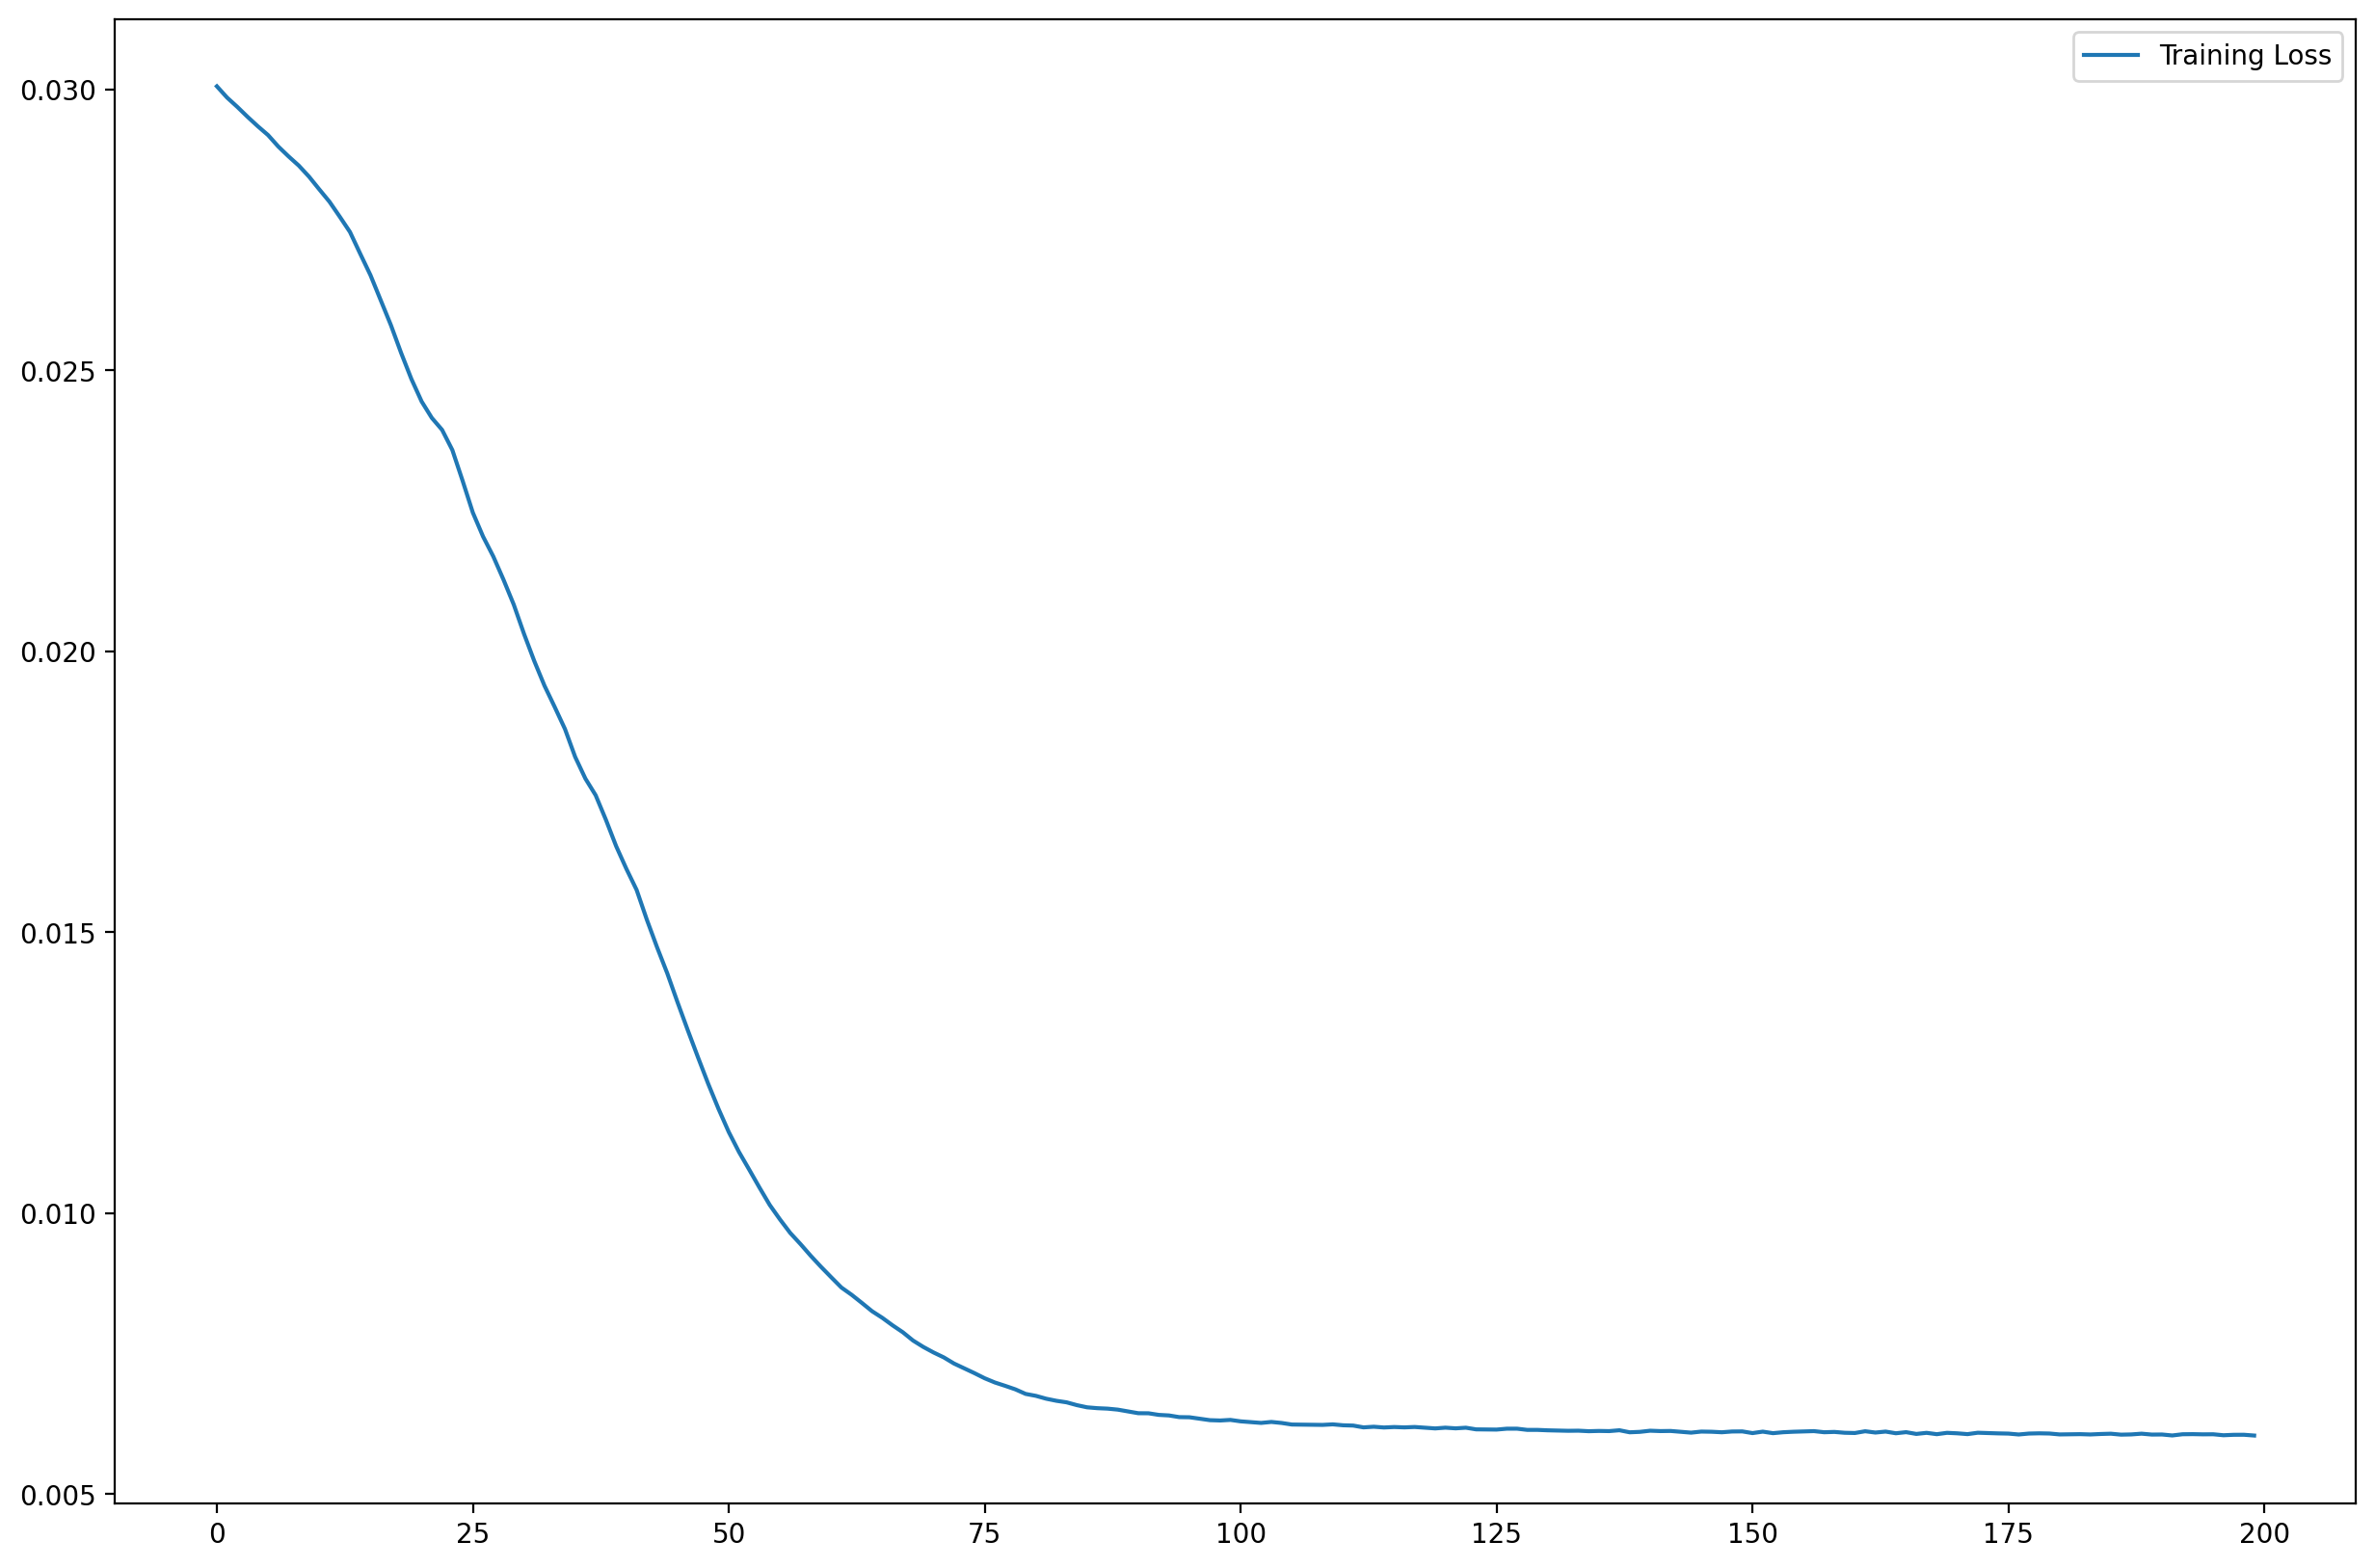

In [29]:
 # YOUR CODE HERE (Many lines!)

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_LSTM.loss_during_training,label='Training Loss')
ax.legend()

En primera instancia observamos la estabilidad de la LSTM en comparación a las RNN, es por ello que no contamos con discontinuidades en la evolución de nuestra "Training Loss". Por otro lado, vemos como la función de coste es similar a la de la RNN a lo largo de 200 iteraciones, por lo que deducimos que en el hecho de realizar "forescasting" y predecir el siguiente instante en el tiempo de las series temporales tendrán un rendimiento (RNN y LSTM) parecido. Esto es normal ya que la memoria del modelo autoregresivo utilizado para generar las señales es pequeña.

We can see how the cost function (MSELoss) is similar in both cases. In terms of predicting the next instant with *teaching forcing*, both models achieve similar performance. Keep in mind that the memory of the autoregressive model that we have used to generate the signals is small...


> **Exercise:** Complete the code to visualize the LSTM prediction of the next value of the signal

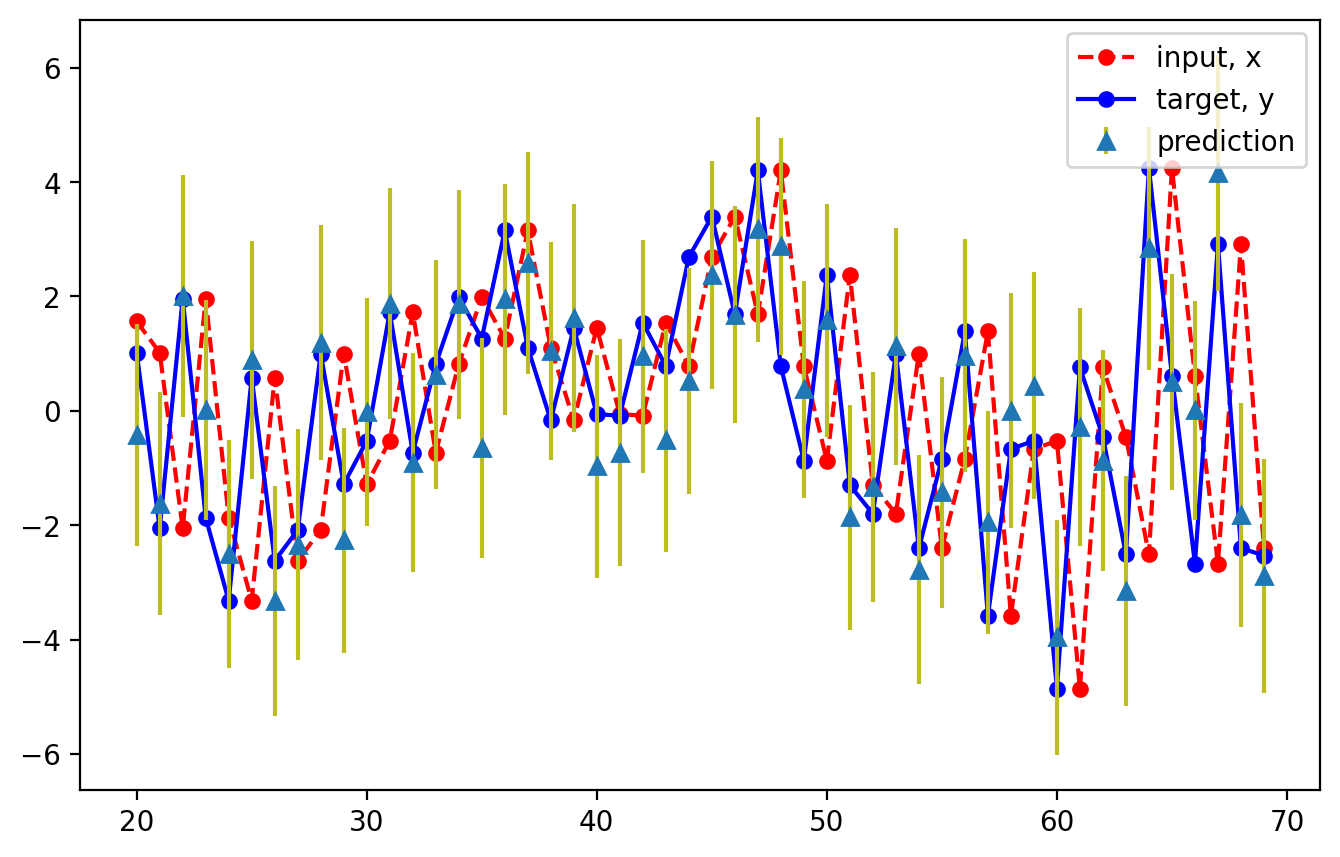

In [32]:
 # YOUR CODE HERE (Many lines!)

# We first evaluate the model for the N signals up to time T_train = 100
X_in = torch.Tensor(X[:,:T_train]).view([N,T_train,1]) 

mean,var,h,sample = my_LSTM.forward(X_in) # YOUR CODE HERE

mean_LSTM = mean.detach().numpy().reshape([N,-1])
std_LSTM = np.sqrt(var.detach().numpy().reshape([N,-1]))

# Initial time point of the representation
t0 = 20

# Final point
tf = 70

signal = 100 # From 1 to N 

# Plot the first training signal and the target
plt.figure(figsize=(8,5))
plt.plot(np.arange(t0,tf,1), X[signal,t0:tf], 'r.--', label='input, x',ms=10) # x
plt.plot(np.arange(t0,tf,1), Y[signal,t0:tf], 'b.-', label='target, y',ms=10) # x
plt.errorbar(np.arange(t0,tf,1), mean_LSTM[signal,t0:tf], 2*std_LSTM[signal,t0:tf], linestyle='None', marker='^',ecolor='tab:olive',label='prediction')
plt.legend(loc='best')

Rendimiento parecido al de las RNN. Teniendo en cuenta que los triangulos son los valores medios predecidos y las lineas verdes hace referencia a la varianza, podemos ver como la señal predicha por la LSTM en referencia al target buscado (la señal original desplazada una unidad de tiempo a la izquierda), es realmente buena. Añadiendo el poco coste computacional y lo rápido que ha sido el entrenamiento (solo 200 mini-batches), podemos concluir en que hemos obtenido realmente buenos resultados.

De esta manera vemos como la LSTM ha aprendido bien la estructura de las series del dataset y tiene capacidad de predicción al siguiente punto temporal.

> **Exercise:** Complete the code to visualize the LSTM forecasting. Plot the LSTM vs RNN vs target for a few signals and discuss the results.

Between t=0 and t=100, we feed the real values
From t=100, we feed the estimated values (forecasting)


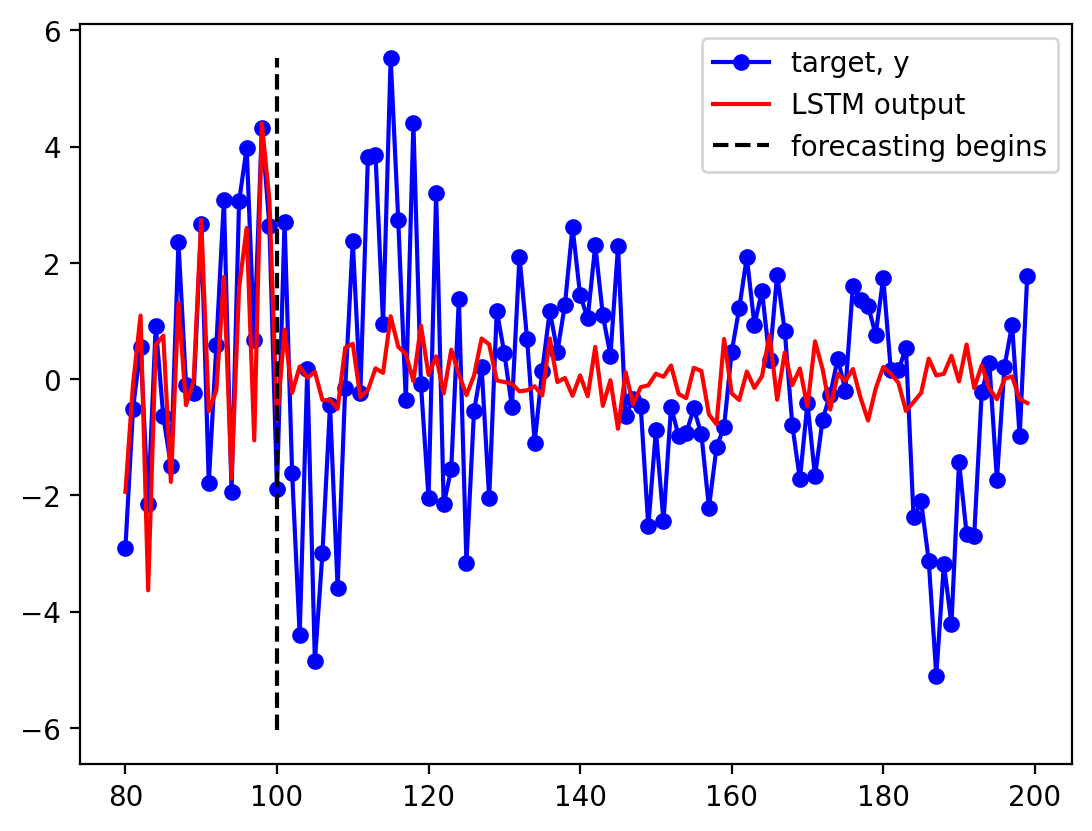

In [33]:
 # YOUR CODE HERE (Many lines!)

# We take the last output of the RNN for the N signals at time T_train
current_input = sample[:,-1,:].view([N,1,1]) 
# And the last state
current_state = h

# Here we store the sampled signals
forecast_LSTM = np.zeros([N,T-T_train])

for t in range(T-T_train):
    
    # En este bucle muestreamos iterativamente el modelo
    
    mean,var,current_state,current_input = my_LSTM.forward(current_input) 
    
    forecast_LSTM[:,t] = current_input.detach().numpy().reshape([-1,])

    
# We concatenate the original ones (until T_train) with the ones we just sampled (from T_train)    
final_LSTM_reconstruct = np.hstack([mean_LSTM,forecast_LSTM])

# Now we plot

t0 = 80

tfinal = 200

plt.plot(np.arange(t0,tfinal,1), Y[signal,t0:tfinal].reshape([-1]), 'b.-', label='target, y',ms=10)  
plt.plot(np.arange(t0,tfinal,1), final_LSTM_reconstruct[signal,t0:tfinal], 'r-', label='LSTM output',ms=10) 
plt.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--',label='forecasting begins')
plt.legend()

plt.legend(loc='best')
print('Between t=0 and t=100, we feed the real values')
print('From t=100, we feed the estimated values (forecasting)')

Como hemos comentado antes la memoria del modelo autoregresivo utilizado para generar las señales es pequeña por lo que en un ejemplo tan sencillo como este, vemos que el rendimiento de la LSTM será relativamente parecido al de la RNN. Sin embargo, lo podemos comprobar con mayor exactitud ploteando ambas predicciones (RNN y LSTM) a la vez.

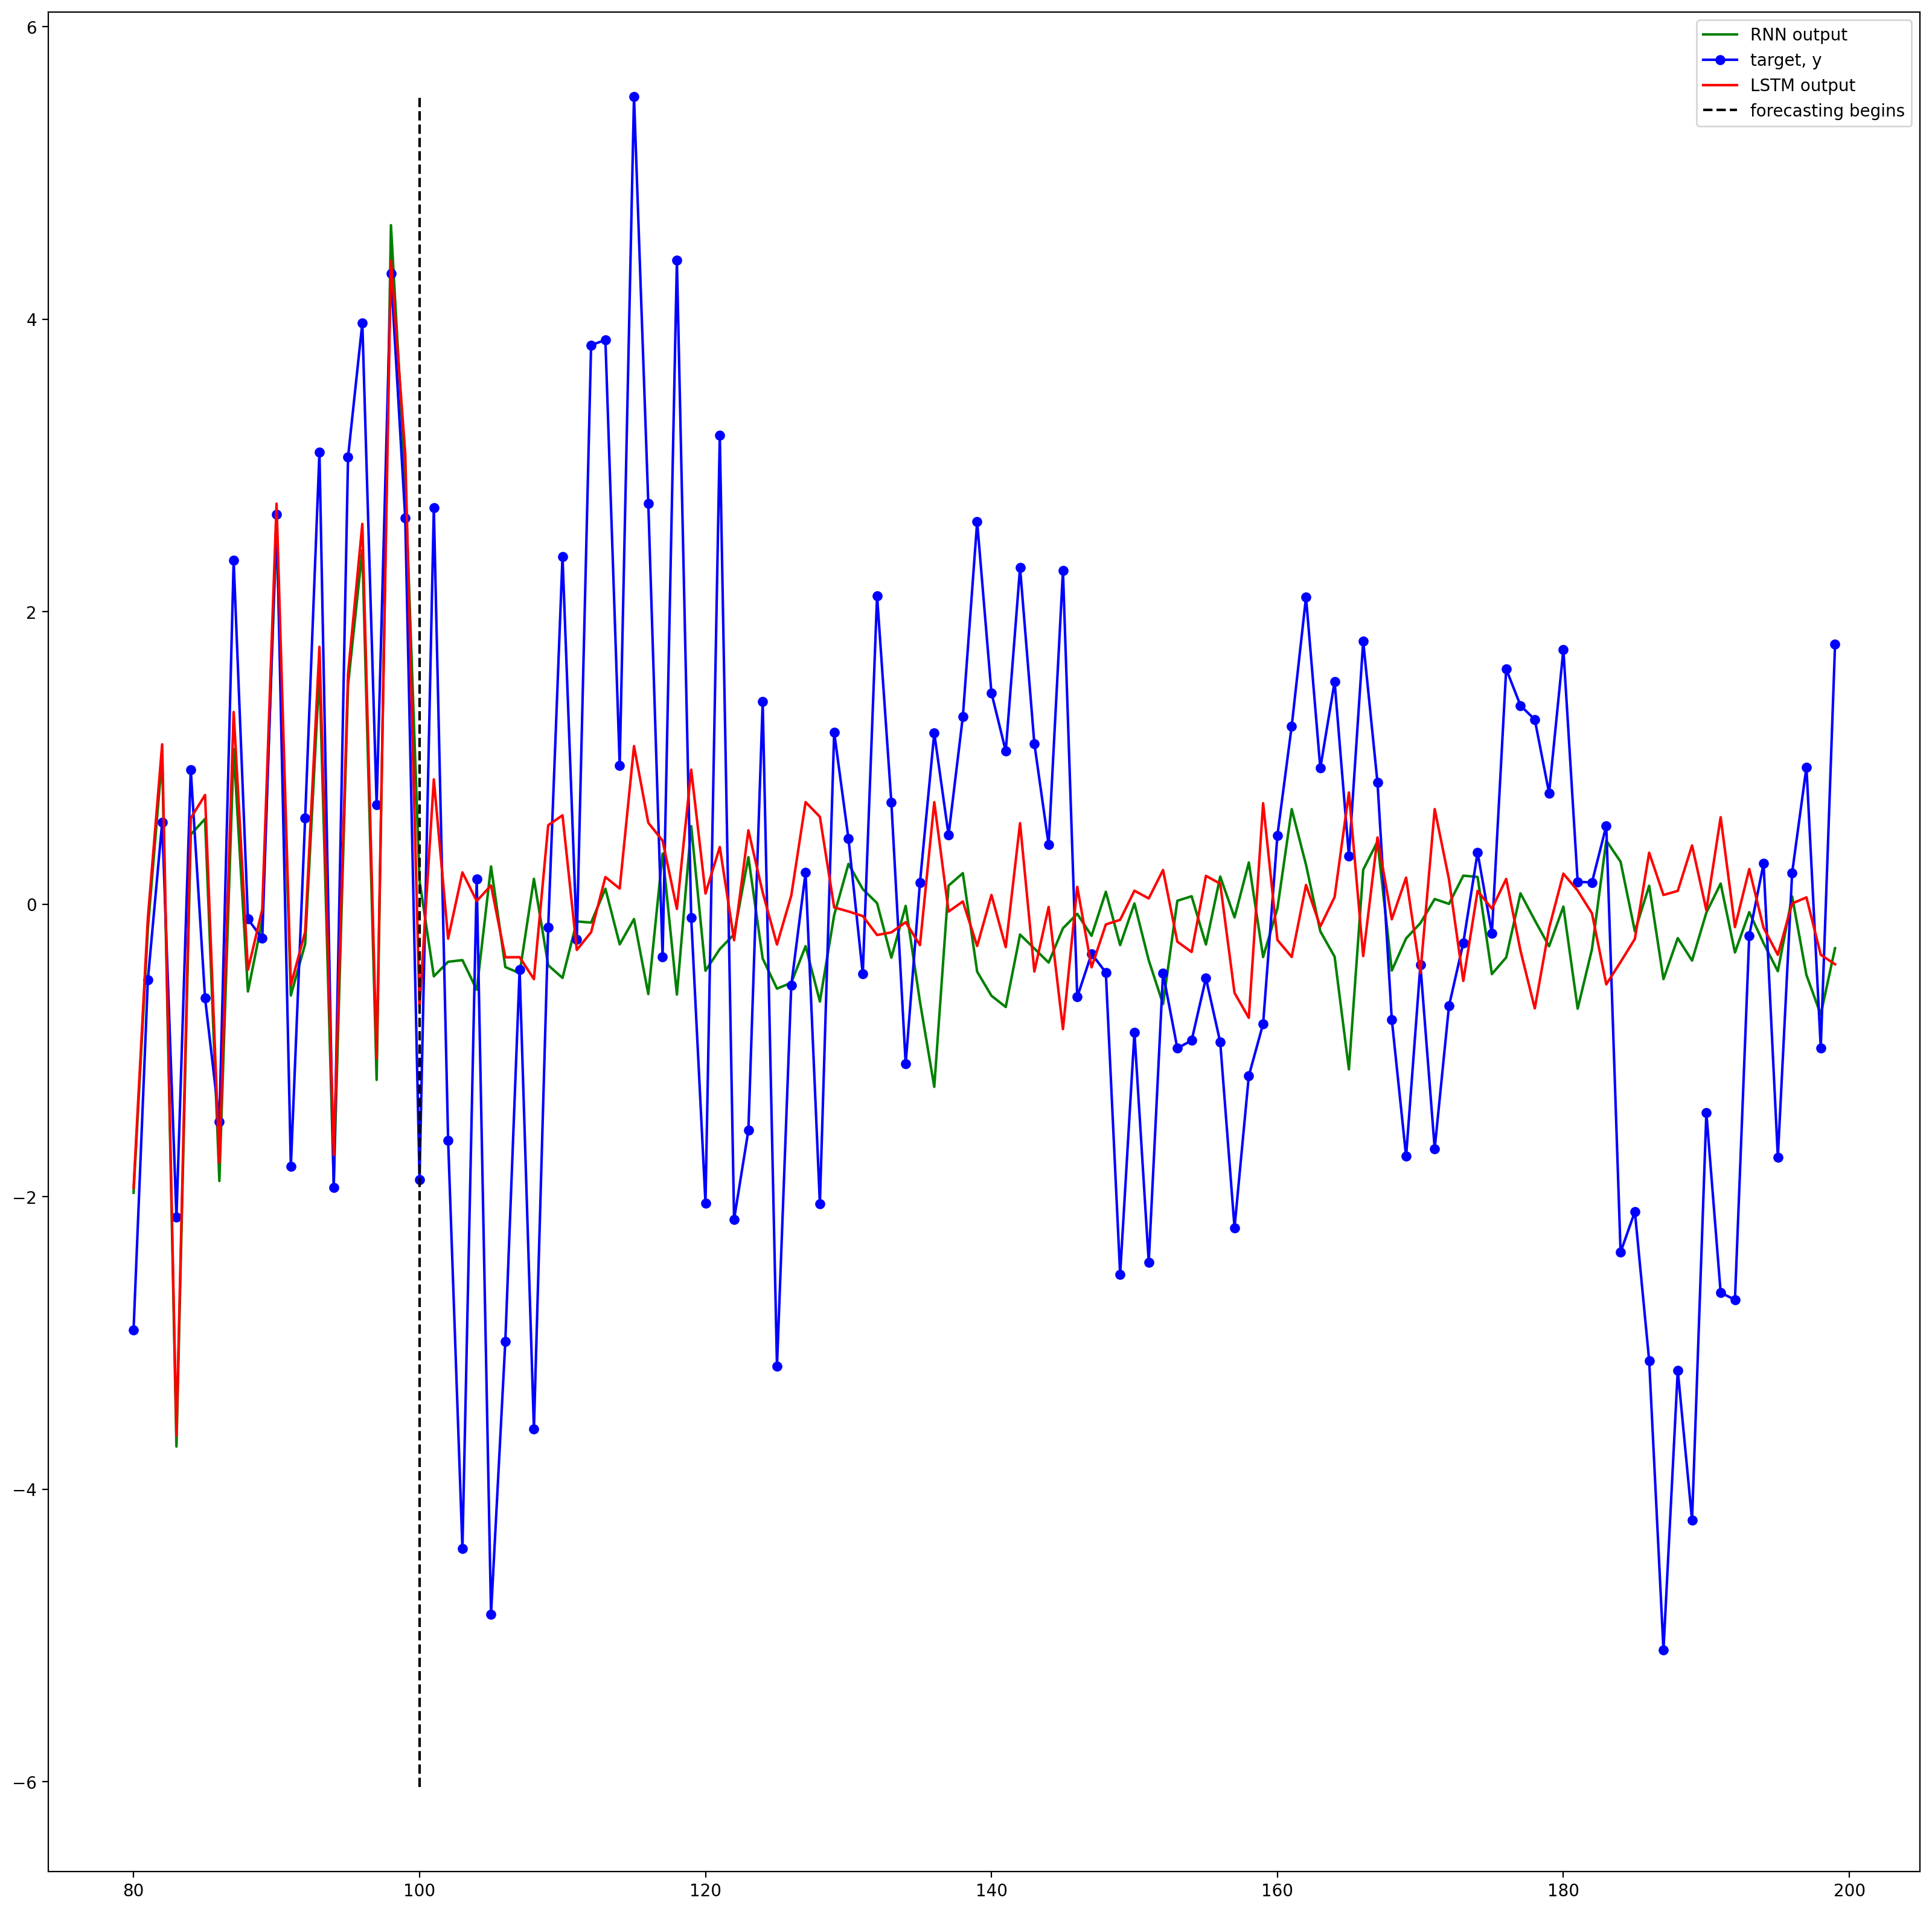

In [34]:
# Mostramos los resultados de la RNN y la LSTM simultaneamente.

fig, ax = plt.subplots(figsize = (20,20))

ax.plot(np.arange(t0,tfinal,1), final_rnn_reconstruct[signal,t0:tfinal], 'g-', label='RNN output',ms=10) 
ax.plot(np.arange(t0,tfinal,1), Y[signal,t0:tfinal].reshape([-1]), 'b.-', label='target, y',ms=10)  
ax.plot(np.arange(t0,tfinal,1), final_LSTM_reconstruct[signal,t0:tfinal], 'r-', label='LSTM output',ms=10) 
ax.plot([T_train,T_train],[np.min(Y[signal,:]),np.max(Y[signal,:])],'k--',label='forecasting begins')
ax.legend()

Como vemos, si bien el rendimiento de la LSTM es ligeramente mejor al de la RNN, ambas tienen resultados similares dado que han captado bien el dinamismo de los datos dando paso a un modelo autoregresivo con memoria reducida.

The conclusions are similar, since both models have captured well the dynamics of the data, generated with an autoregressive model with reduced memory.